# Predicting COVID-19 cases with ARIMA and ANNs

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import itertools
import warnings
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

<IPython.core.display.Javascript object>

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

<IPython.core.display.Javascript object>

In [ ]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
active_df.plot(figsize=(10, 5))
plt.show()

In [ ]:
confirmed_df.plot(figsize=(10, 5))
plt.show()

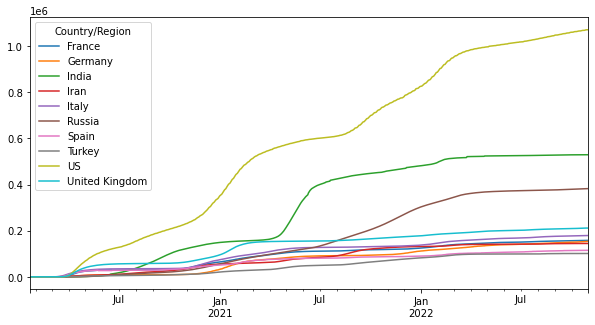

<IPython.core.display.Javascript object>

In [6]:
deaths_df.plot(figsize=(10, 5))
plt.show()

In [7]:
confirmed_df.head()

Country/Region,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
2020-01-22,0,0,0,0,0,0,0,0,1,0
2020-01-23,0,0,0,0,0,0,0,0,1,0
2020-01-24,2,0,0,0,0,0,0,0,2,0
2020-01-25,3,0,0,0,0,0,0,0,2,0
2020-01-26,3,0,0,0,0,0,0,0,5,0


<IPython.core.display.Javascript object>

### Train test split

In [8]:
active_train = active_df[:"2021-05-04"]
active_test = active_df["2021-05-05":"2021-08-04"]
confirmed_train = confirmed_df[:"2022-01-01"]
confirmed_test = confirmed_df["2022-01-02":"2022-10-31"]

<IPython.core.display.Javascript object>

## Model Selection

### Determining order of differencing (d)

In [9]:
# Original Series
country = "India"
df = pd.DataFrame((confirmed_train[country].to_numpy()), columns={"cases"})
df.transform("sqrt")

,cases
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
706,5899.905592
707,5901.020251
708,5902.440512
709,5904.369484


<IPython.core.display.Javascript object>

In [10]:
result = adfuller(df)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.182494
p-value: 0.971262
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


<IPython.core.display.Javascript object>

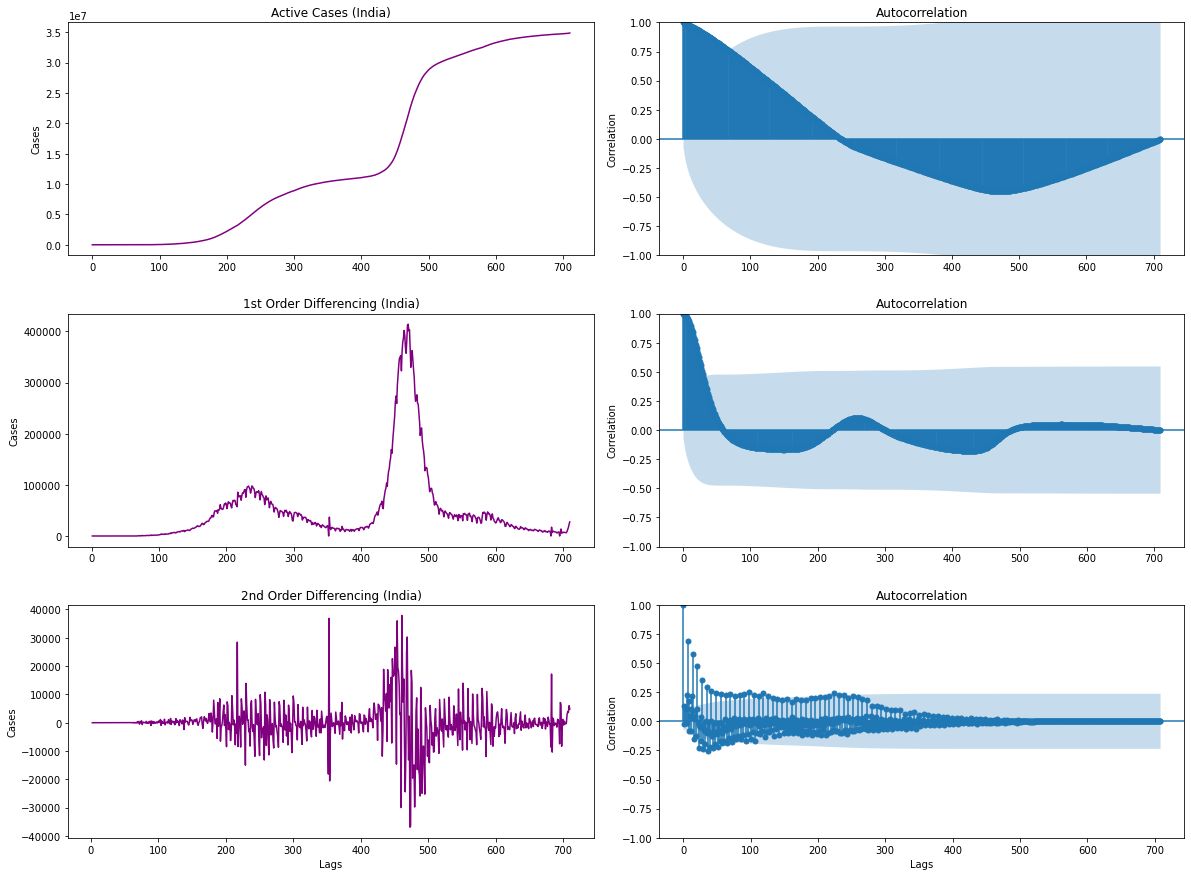

<IPython.core.display.Javascript object>

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

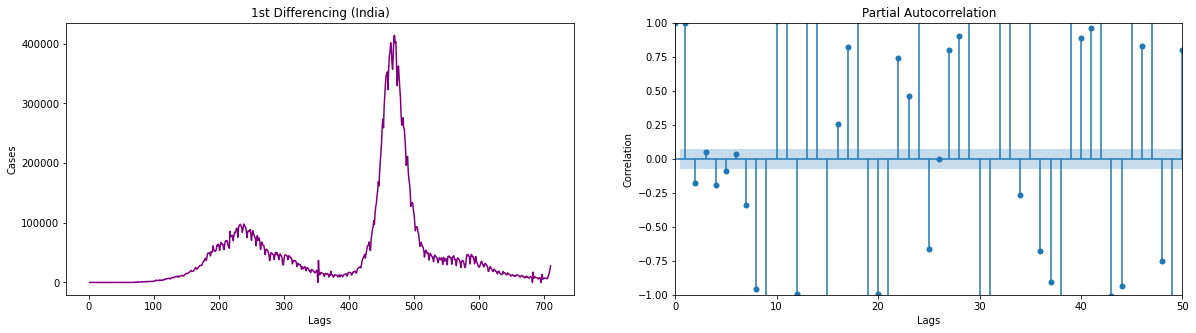

<IPython.core.display.Javascript object>

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=df.shape[0] / 2 - 1)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1 is quite significant since it is well above the significance limit, the blue region.
So we will use:
$$p = 1$$

### Determining order of Moving Average (q)

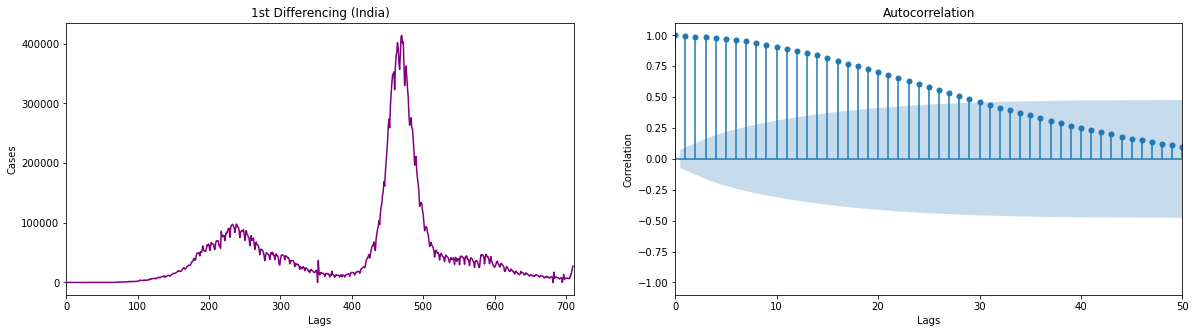

<IPython.core.display.Javascript object>

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1.1, 1.1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 16, the correlation is above the significance range and so we can conclude that: $$q \in [1, 30]$$

In [14]:
# Define the p, d, q parameters
p = range(1, 2)
d = range(1, 2)
q = range(1, 31)

<IPython.core.display.Javascript object>

In [15]:
pdq = list(itertools.product(p, d, q))
RMSE = []
ARIMA_model = []

for param in pdq:
    mod = sm.tsa.arima.ARIMA(
        df, order=param, enforce_stationarity=False, enforce_invertibility=False
    )
    results = mod.fit()
    print("ARIMA{} - RMSE:{}".format(param, math.sqrt(results.mse)))
    RMSE.append(math.sqrt(results.mse))
    ARIMA_model.append(param)

ARIMA(1, 1, 1) - RMSE:6819.899226334052
ARIMA(1, 1, 2) - RMSE:6813.541940665559
ARIMA(1, 1, 3) - RMSE:6783.945139809853
ARIMA(1, 1, 4) - RMSE:6783.805378170217
ARIMA(1, 1, 5) - RMSE:6225.900070017582
ARIMA(1, 1, 6) - RMSE:6102.403779269715
ARIMA(1, 1, 7) - RMSE:5427.288089226565
ARIMA(1, 1, 8) - RMSE:5406.59553747819
ARIMA(1, 1, 9) - RMSE:5387.499871650627
ARIMA(1, 1, 10) - RMSE:5385.711991223667
ARIMA(1, 1, 11) - RMSE:5355.639667827312
ARIMA(1, 1, 12) - RMSE:5309.945869892551
ARIMA(1, 1, 13) - RMSE:5175.584389665989
ARIMA(1, 1, 14) - RMSE:4944.17274183655
ARIMA(1, 1, 15) - RMSE:4966.454607378562
ARIMA(1, 1, 16) - RMSE:5008.94224036374
ARIMA(1, 1, 17) - RMSE:4962.161674225107
ARIMA(1, 1, 18) - RMSE:4886.422911601794
ARIMA(1, 1, 19) - RMSE:4864.649426355153
ARIMA(1, 1, 20) - RMSE:4725.341326462597
ARIMA(1, 1, 21) - RMSE:4534.936836303901
ARIMA(1, 1, 22) - RMSE:4494.162622738618
ARIMA(1, 1, 23) - RMSE:4482.300049912301
ARIMA(1, 1, 24) - RMSE:4480.437967591688
ARIMA(1, 1, 25) - RMSE:4480.

<IPython.core.display.Javascript object>

In [16]:
print(
    "The smallest RMSE is {} for model ARIMA {}".format(
        min(RMSE), ARIMA_model[RMSE.index(min(RMSE))]
    )
)

The smallest RMSE is 4413.745648970129 for model ARIMA (1, 1, 30)


<IPython.core.display.Javascript object>

In [17]:
finalmod = sm.tsa.arima.ARIMA(
    df,
    order=ARIMA_model[RMSE.index(min(RMSE))],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = finalmod.fit()

<IPython.core.display.Javascript object>

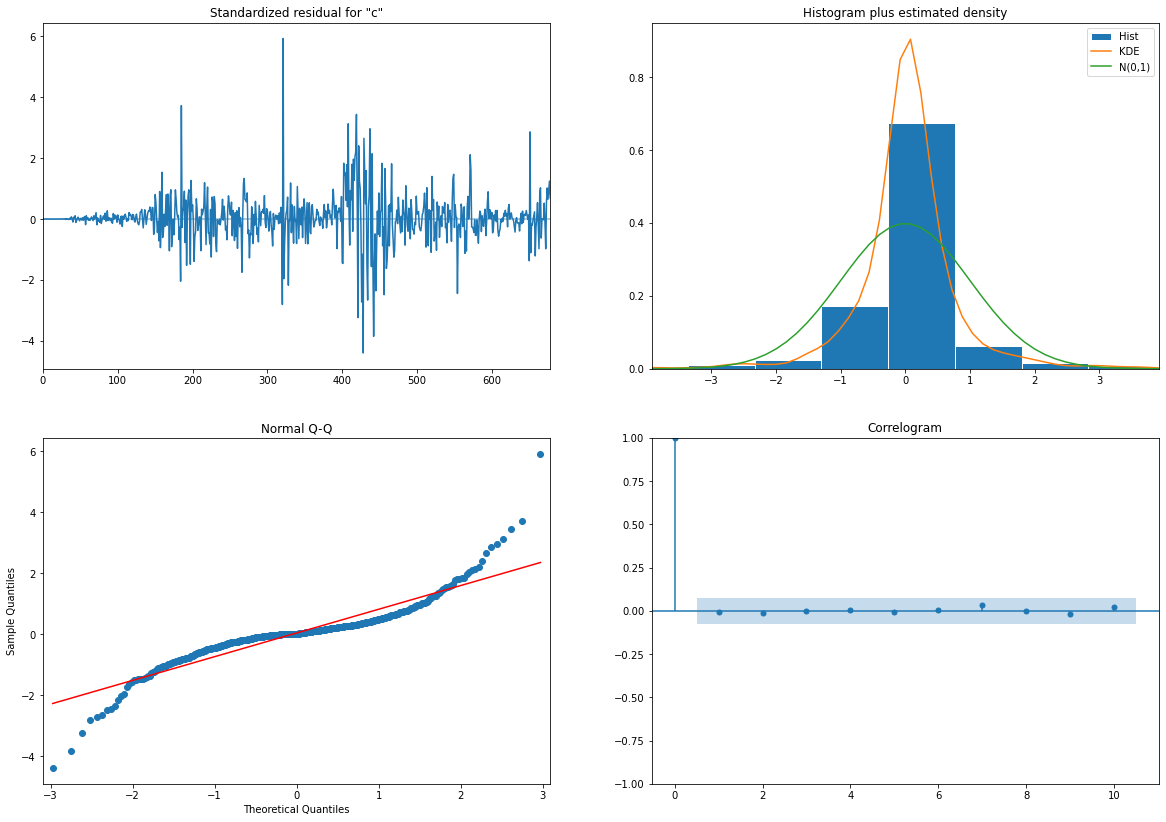

<IPython.core.display.Javascript object>

In [18]:
results.plot_diagnostics(figsize=(20, 14))
plt.savefig("Graphs/diagnostics_arima.jpg")
plt.show()

In [19]:
actual = pd.DataFrame((confirmed_df[country].to_numpy()), columns={"cases"})

<IPython.core.display.Javascript object>

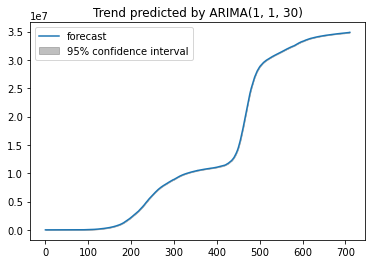

<IPython.core.display.Javascript object>

In [20]:
plot_predict(results, figsize=(10, 5))
plt.title("Trend predicted by ARIMA(1, 1, 30)")
plt.savefig("Graphs/predicted_confirmed_india.jpg")
plt.show()

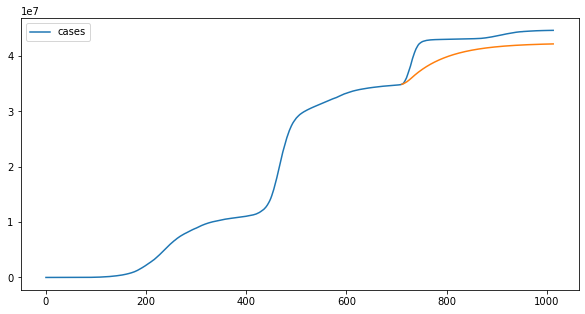

<IPython.core.display.Javascript object>

In [24]:
ax = actual.plot(figsize=(10, 5))
forecast = results.forecast(303)
forecast.plot(ax=ax, label="Forecast")
plt.savefig("Graphs/forecast_confirmed_india.jpg")
plt.show()